In [1]:
import os 
import sys
import time
import pickle
import logging
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import fbeta_score, accuracy_score

import utils
import data_prep as prep
import train_select as ts

logging.basicConfig(
    format='%(levelname)s %(message)s',
    stream=sys.stdout, level=logging.INFO)

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [2]:
random_state = 42
batch_dir = "dataset/batches"
test_ratio = .15

partial_fit_classifiers = {
    'SGD': SGDClassifier(random_state=random_state, loss='log'),
    'Perceptron': Perceptron(random_state=random_state),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(random_state=random_state)
}

A total of 36 batchs will be held out as test set. During training, every tenth batch will be used as a validation set. 

In [3]:
test_batch_names, train_batch_names = ts.split_test(batch_dir=batch_dir, test_ratio=test_ratio)

INFO Number of test batches: 14
INFO Number of train batches: 85


In [4]:
results = ts.train_predict(partial_fit_classifiers, train_batch_names, n_train = 85)

INFO iter 10 / 85
INFO Number of validation sample: 6069
INFO ===== F-beta score (beta=0.5) ==========
INFO SGD: 0.6759379042690815
INFO Perceptron: 0.6262351778656127
INFO NB Multinomial: 0.5493050959629385
INFO P-A: 0.515658747300216
INFO ========================================
INFO iter 20 / 85
INFO Number of validation sample: 6360
INFO ===== F-beta score (beta=0.5) ==========
INFO SGD: 0.6345134256883872
INFO Perceptron: 0.5344894525689142
INFO NB Multinomial: 0.5821517931609675
INFO P-A: 0.5180263319798203
INFO ========================================
INFO iter 30 / 85
INFO Number of validation sample: 5890
INFO ===== F-beta score (beta=0.5) ==========
INFO SGD: 0.7272727272727272
INFO Perceptron: 0.4897852278679937
INFO NB Multinomial: 0.5931920574003005
INFO P-A: 0.535472209670131
INFO ========================================
INFO iter 40 / 85
INFO Number of validation sample: 5897
INFO ===== F-beta score (beta=0.5) ==========
INFO SGD: 0.7216608084358523
INFO Perceptron: 0.65

In [5]:
results

{'NB Multinomial': {'acc_test': 0.87773795300677027,
  'acc_train': [0.87913043478260866,
   0.87907949790794981,
   0.87736263736263731,
   0.88629856850715749,
   0.87577897798088911,
   0.87406532861078312,
   0.88037462750106432,
   0.87136229439055246,
   0.87034713508992056,
   0.87659744408945683,
   0.87859424920127793,
   0.87106257874842508,
   0.88949416342412446,
   0.85795186408683344,
   0.88748191027496381,
   0.8869731800766284,
   0.89060731799321013,
   0.8681870892926169,
   0.88085106382978728,
   0.8771508603441377,
   0.87835134053621444,
   0.86574870912220314,
   0.87109044801352498,
   0.8749517560787341,
   0.89159376188664896,
   0.87601704765594735,
   0.87859057832248177,
   0.88112419293581468,
   0.87773933102652824,
   0.878,
   0.87839999999999996,
   0.87536966624419099,
   0.86974789915966388,
   0.87108013937282225,
   0.87707358570820926,
   0.87539432176656151,
   0.87003341997771999,
   0.86480777355302074,
   0.85601404741000875,
   0.87195373812

# Plot results

In [24]:
n_train = results['SGD']['n_train']
n_cumsum = np.cumsum(results['SGD']['n_train'])

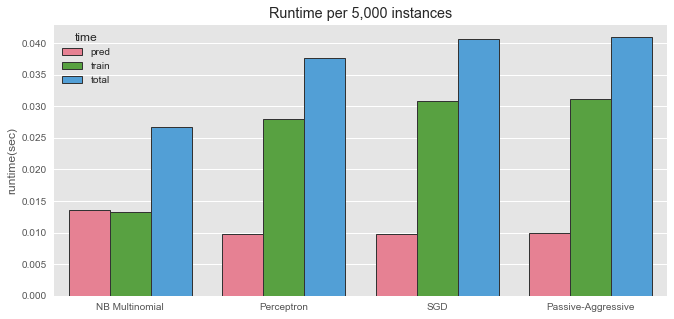

In [41]:
time_res = get_time_res(results)
plot_time(time_res)

In [6]:
results['SGD'].keys()

dict_keys(['acc_test', 'pred_time', 'f_test', 'f_train', 't0', 'n_train_pos', 'train_time', 'n_train', 'acc_train'])

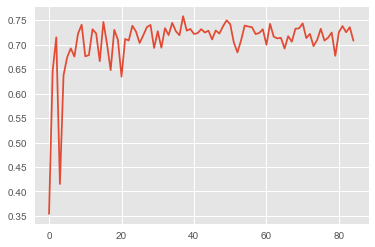

In [8]:
plt.plot(results['SGD']['f_train'])

In [15]:
def get_score(results):
    res = []
    for k in partial_fit_classifiers.keys():
        acc_train = results[k]['acc_train']
        f_train = results[k]['f_train']
        res.append((k, acc_train, f_train))
    return res

In [17]:
res = pd.DataFrame(get_score(results))
res.head()

,0,1,2
0,SGD,"[0.854776847978, 0.888063756566, 0.90173594521...","[0.35418236624, 0.646871686108, 0.71474290591,..."
1,NB Multinomial,"[0.869944211994, 0.867958703133, 0.88007644529...","[0.599386170789, 0.591715976331, 0.63899982635..."
2,Perceptron,"[0.867329149233, 0.875203767433, 0.89058767319...","[0.519671168526, 0.61078187727, 0.672172076051..."
3,Passive-Aggressive,"[0.852336122734, 0.867415323311, 0.89026915113...","[0.361204013378, 0.590416428979, 0.67407709565..."


In [78]:
def plot_score(results):
    my_col = sns.color_palette("husl", 4)
    plt.figure(figsize=(11, 5))
    ax1 = plt.subplot(121)
    n = np.cumsum(results['SGD']['n_train'])
    len_n = len(n)
    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(n, pd.Series(results[clf_name]['acc_train'][:len_n]).rolling(window=5).mean(),
                color=my_col[i], linewidth=2.5)
    plt.ylabel("Accuracy")
    plt.xlabel("Training samples (#)")
    plt.legend(loc = "best", labels = partial_fit_classifiers.keys())
    plt.title("Accuracy on training set")
    
    ax2 = plt.subplot(122, sharey=ax1)
    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(n, pd.Series(results[clf_name]['f_train'][:len_n]).rolling(window=5).mean(),
                color=my_col[i], linewidth=2.5)
    plt.ylabel("F-score")
    plt.xlabel("Training samples (#)")
    plt.title("F score (beta=0.5) on training set")
    plt.savefig("assets/compare_score.png")
    plt.show()


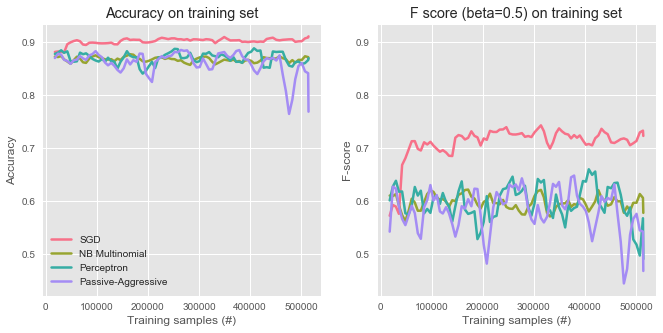

In [77]:
plot_score(results)